# Segmentation example
This segmentation example shows a workflow to develop a model,
and use base + mask images of boundaries to train an AI to detect the boundaries.

The model results are terrible, as we will be developing the actual model during our construciton phase,
but this provides a valid technical demonstrator of the overall process.

In [1]:
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import tensorflow as tf
import cv2 as cv

from tensorflow.keras.layers import Input, Conv2D, Dropout, Activation, UpSampling2D, GlobalMaxPooling2D, multiply, BatchNormalization, Conv2DTranspose, Concatenate
from keras.layers.pooling import MaxPooling2D
from tensorflow.keras.models import Model, load_model
from keras.layers.core import Dropout, Lambda
from keras.layers.merge import concatenate
from IPython.display import Image, clear_output
from tensorflow import keras
from keras import backend as K

import pandas as pd

#https://www.kaggle.com/code/balraj98/unet-resnet50-frontend-road-segmentation-pytorch

DATA_DIR = '../DataSets/archive/tiff/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

class_dict = pd.read_csv("../DataSets/archive/label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

img_shape = (512, 512)
batch_size = 4

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

C:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [2]:
def build_data(PATH):
    data = []
    filenames = sorted(os.listdir(PATH))
    for name in filenames:
        data.append(PATH + '/' + name)
    return data

sat_image = build_data(x_train_dir)
mask_image = build_data(y_train_dir)

len(sat_image), len(mask_image)

(1108, 1108)

In [3]:
# Add to datafram
df = pd.DataFrame({
    'Image' : sat_image,
    'Mask' : mask_image
})

df

,Image,Mask
0,../DataSets/archive/tiff/train/10078660_15.tiff,../DataSets/archive/tiff/train_labels/10078660...
1,../DataSets/archive/tiff/train/10078675_15.tiff,../DataSets/archive/tiff/train_labels/10078675...
2,../DataSets/archive/tiff/train/10078690_15.tiff,../DataSets/archive/tiff/train_labels/10078690...
3,../DataSets/archive/tiff/train/10078705_15.tiff,../DataSets/archive/tiff/train_labels/10078705...
4,../DataSets/archive/tiff/train/10078720_15.tiff,../DataSets/archive/tiff/train_labels/10078720...
...,...,...
1103,../DataSets/archive/tiff/train/27028705_15.tiff,../DataSets/archive/tiff/train_labels/27028705...
1104,../DataSets/archive/tiff/train/27028720_15.tiff,../DataSets/archive/tiff/train_labels/27028720...
1105,../DataSets/archive/tiff/train/27178705_15.tiff,../DataSets/archive/tiff/train_labels/27178705...
1106,../DataSets/archive/tiff/train/99238660_15.tiff,../DataSets/archive/tiff/train_labels/99238660...


In [4]:
def modify_mask(mask):
    mask = np.expand_dims(mask, axis = 2)
    t_mask = np.zeros(mask.shape)
    np.place(t_mask[:, :, 0], mask[:, :, 0] >=100, 1)
    return t_mask

def map_function(img, mask):
    img, mask = plt.imread(img.decode()), plt.imread(mask.decode())
    img = cv.resize(img, img_shape)
    mask = modify_mask(cv.resize(mask, img_shape))
    
    img = img/255.0
    # transformed = transform(image=img, mask=mask)
    # img = transformed['image']
    # mask = transformed['mask']

#     mask = modify_mask(mask)
    
    return img.astype(np.float64), mask.astype(np.float64)

In [5]:
def create_dataset(data):
    dataset = tf.data.Dataset.from_tensor_slices((data['Image'], data['Mask']))
    dataset = dataset.shuffle(1000)
    dataset = dataset.map(lambda img, mask : tf.numpy_function(
                    map_function, [img, mask], [tf.float64, tf.float64]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(batch_size)

    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return dataset

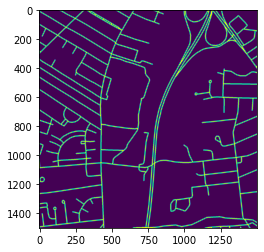

In [6]:
img = plt.imread(y_train_dir + '/10828810_15.tif')
img = modify_mask(img)

plt.imshow(img)

In [7]:
def dice_coef(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0) 
 
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [8]:
train_dataset = create_dataset(df)
img, mask = next(iter(train_dataset))
img.shape, mask.shape

(TensorShape([4, 512, 512, 3]), TensorShape([4, 512, 512, 1]))

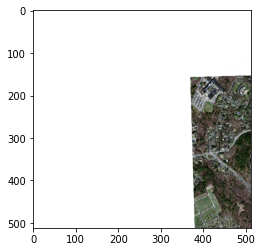

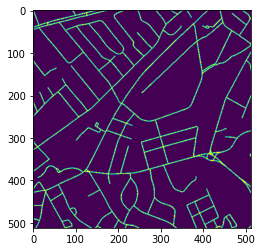

In [9]:
plt.imshow(img[1])
plt.show()
plt.imshow(mask[1])
plt.show()

## Setup the model
From https://github.com/yingkaisha/keras-unet-collection/blob/main/examples/segmentation_unet-three-plus_oxford-iiit.ipynb

In [10]:
def unet(num_classes = 1, input_shape= (img_shape[0],img_shape[1], 3)):
  inp = Input(input_shape)
  # Block 1
  x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(inp)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
  x = BatchNormalization()(x)
  block_1_out = Activation('relu')(x)
  x = MaxPooling2D()(block_1_out)
  # Block 2
  x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
  x = BatchNormalization()(x)
  block_2_out = Activation('relu')(x)
  x = MaxPooling2D()(block_2_out)
  # Block 3
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
  x = BatchNormalization()(x)
  block_3_out = Activation('relu')(x)
  x = MaxPooling2D()(block_3_out)
  # Block 4
  x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
  x = BatchNormalization()(x)
  block_4_out = Activation('relu')(x)
  
 
  
  x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP2')(block_4_out)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Concatenate()([x, block_3_out])
  x = Conv2D(256, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  # UP 3
  x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP3')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Concatenate()([x, block_2_out])
  x = Conv2D(128, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(128, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  # UP 4
  x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP4')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Concatenate()([x, block_1_out])
  x = Conv2D(64, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(64, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(num_classes, (3, 3), activation='sigmoid', padding='same')(x)
 
  model = Model(inputs=inp, outputs=x)
  adam = tf.keras.optimizers.Adam(lr=0.0001)
  model.compile(optimizer=adam,
                  loss=dice_coef_loss,
                  metrics=[dice_coef])
    # model.summary()
  return model

## Compile the model

In [11]:
model = unet()

C:\Python310\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Show functions
These functions allow the images to be displayed
We also show the predictions before the model is trained

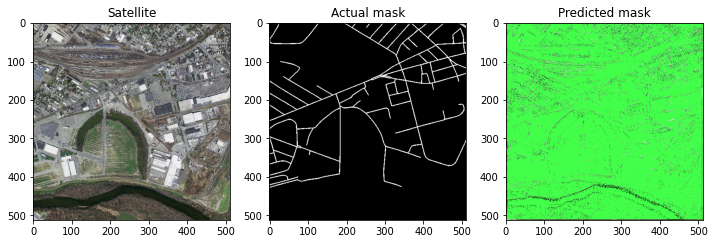

In [12]:
color = [66, 255, 73]
color = [i/255.0 for i in color]

def placeMaskOnImg(img, mask):
    np.place(img[:, :, :], mask[:, :, :] >= 0.5, color)
    return img

def make_pred_good(pred):
#     pred = pred.numpy()
    pred = pred[0][:, :, :]
    pred = np.repeat(pred, 3, 2)
    return pred

def make_pred_good(pred):
#     pred = pred.numpy()
    pred = pred[0][:, :, :]
    pred = np.repeat(pred, 3, 2)
    return pred

def display(img, mask):
    plt.figure(figsize = (12,10))
    
    mask = modify_mask(cv.resize(mask, img_shape))
    img = (img/255.0)

    img = np.expand_dims(cv.resize(img, (512, 512)), 0)
    img = img.astype(np.float32)
    
    pred = make_pred_good(model(img))
    mask = make_pred_good(np.expand_dims(mask, axis = 0))
    
    plt.subplot(1,3,1)
    plt.title("Satellite")
    plt.imshow(img[0])
    plt.subplot(1,3,2)
    plt.title('Actual mask')
    plt.imshow(mask)
    plt.subplot(1,3,3)
    plt.title('Predicted mask')
    pred = placeMaskOnImg(img[0], pred)
    plt.imshow(pred)
    
    plt.show()
    
n = 1
    
test_img = sorted(os.listdir(x_test_dir))[n:n+10]
test_mask = sorted(os.listdir(y_test_dir))[n:n+10]
    
display(plt.imread(x_test_dir + '/' + test_img[0]), plt.imread(y_test_dir + '/' + test_mask[0]))

## Define callbacks
These callbacks are run after each epoch
They show the current prediction result and save the model

In [15]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        display(plt.imread(x_test_dir + '/' + test_img[0]), plt.imread(y_test_dir + '/' + test_mask[0]))
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model4.h5', save_best_only=True),
    DisplayCallback()
]

# Train the model

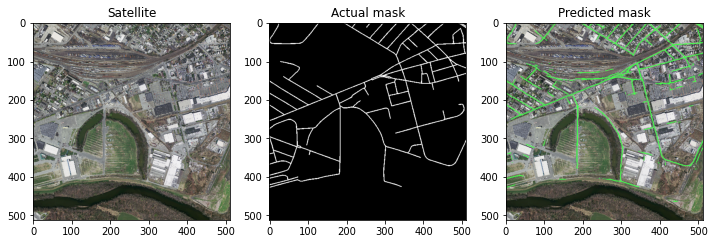


Sample Prediction after epoch 20

277/277 [==============================] - 100s 360ms/step - loss: 0.2645 - dice_coef: 0.7355


In [16]:
EPOCHS = 20

model_history = model.fit(train_dataset,
                          callbacks=callbacks,
                          epochs=EPOCHS)

In [ ]:
## Show some predictions using our trained model

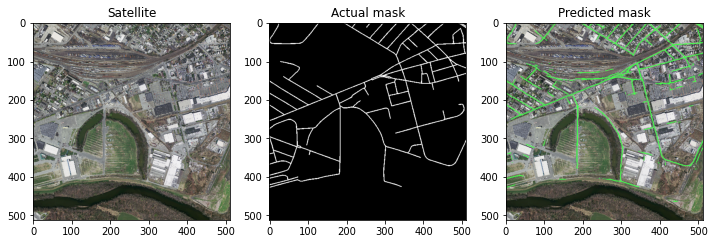

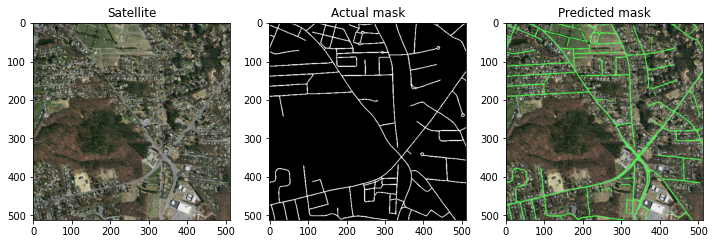

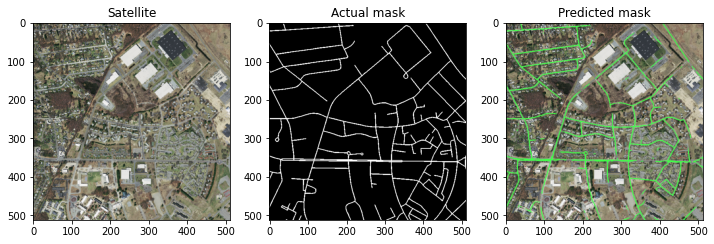

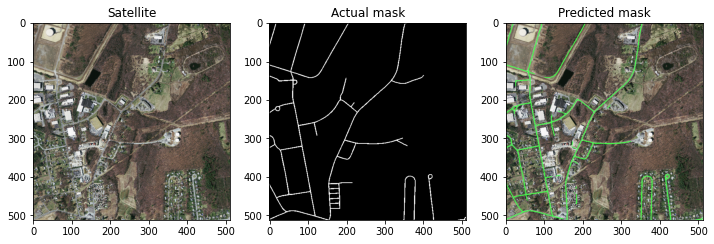

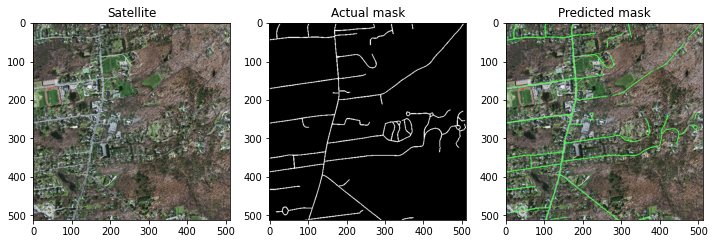

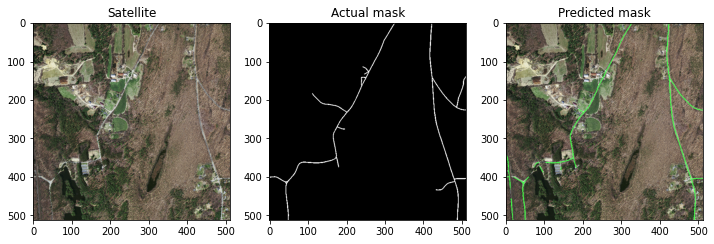

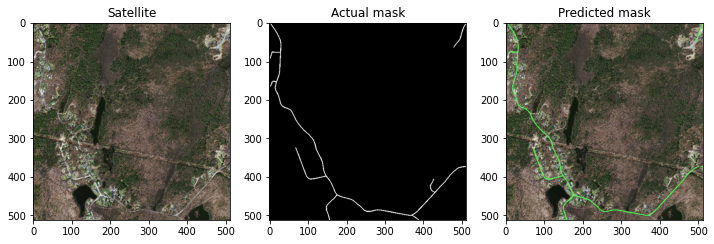

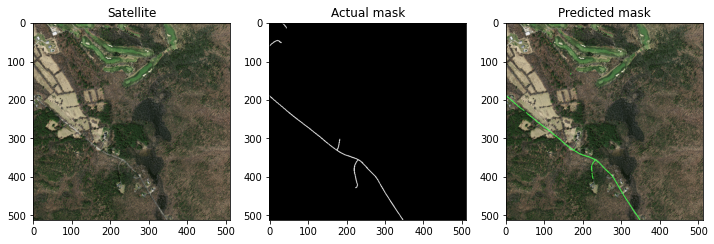

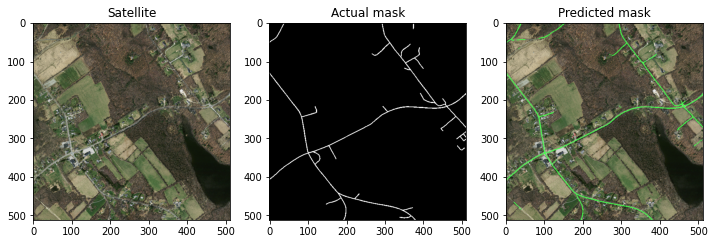

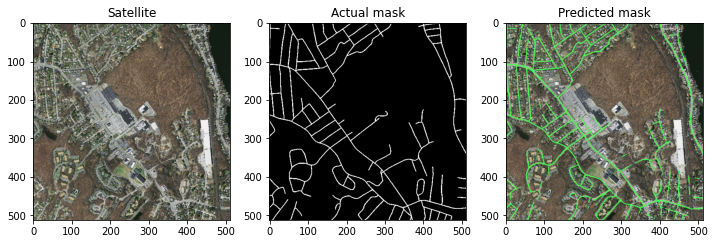

In [18]:
for i in range(10):
    display(plt.imread(x_test_dir + '/' + test_img[i]), plt.imread(y_test_dir + '/' + test_mask[i]))